### Multi Label Classification and Focal Loss
### Assignment # 5 - Part II
### Muhammad Sufian (MSDS17037)

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

### Load Dataset from Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip "/content/drive/My Drive/Semester # 05/DL/A_05_Part_02_Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: A_05_Part_02_Dataset/Train/normal/52f18c9e-7262-4fcc-a6bc-78e707214886.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52f53bb5-81fb-408b-adc7-2f8ae8932b31.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52fee036-272a-455a-9714-b6ff73e28403.png  
  inflating: A_05_Part_02_Dataset/Train/normal/535c2337-e755-43ea-ab1d-6547a584776d.png  
  inflating: A_05_Part_02_Dataset/Train/normal/536ba3bf-b867-4035-b483-35e9cbda9c0f.png  
  inflating: A_05_Part_02_Dataset/Train/normal/538d24ba-8a55-4445-b0d5-f9e5812fdd49.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53bae9fc-3bb2-4684-b986-84bf7aa2e5a2.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53bed796-1a7b-406b-b37c-d37facb41158.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53c275e1-e692-4445-bb4f-b740d117712f.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53c369ae-d8f9-4e44-b212-c6e2dc6ef580.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53

In [0]:
data_dir =  'A_05_Part_02_Dataset'

In [0]:
import os
os.rename('/content/A_05_Part_02_Dataset/Train/covid-19','/content/A_05_Part_02_Dataset/Train/covid')

In [0]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(256),
                                       transforms.CenterCrop(256),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.3, 0.3, 0.3])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(256),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.3, 0.3, 0.3])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(256),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.3, 0.3, 0.3])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/Validation', transform=validation_transforms)
#test_data = datasets.ImageFolder(data_dir + '/Test', transform=test_transforms)

train_batch_size = 64
validation_batch_size = 6
test_batch_size = 6

#data loaders 
trainloader = torch.utils.data.DataLoader(train_data, batch_size=train_batch_size, shuffle=True) 
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=validation_batch_size, shuffle=True)
#testloader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


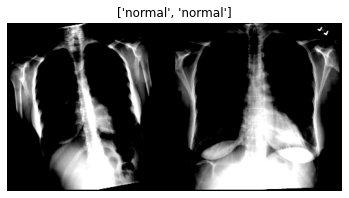

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs[0:2], classes[0:2])

### Load pre-trained ResNet18

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18 (pretrained=True)
#print(resnet18)

### Changes in FC Layers

In [0]:
num_features = resnet18.fc.out_features
in_features = resnet18.fc.in_features
resnet18.fc=nn.Linear(in_features, 3)
#print(resnet18)

### UnFreezing all the layers

In [0]:
for param in resnet18.modules():
    param.requires_grad = True

### Loss function and optimizer

In [0]:
def focal_loss(y_hat, y):
    alpha = 0.25
    gamma = 2  
    
    ce = - nn.functional.binary_cross_entropy_with_logits(y_hat, y)
    prob = torch.exp(-ce)

    fl = -( (1-prob)**gamma ) * ce
    return alpha * fl

In [0]:
Epochs = 5
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [0]:
def print_confusion_matrix(conf):
    print("\n")
    print("")
    print("COVID vs other Classes    ",conf[0,0,0],"   ",conf[0,0,1])
    print("                          ",conf[0,1,0],"   ",conf[0,1,1])
    print("")
    print("Normal vs other Classes   ",conf[1,0,0],"   ",conf[1,0,1])
    print("                          ",conf[1,1,0],"   ",conf[1,1,1])
    print("")
    print("Pneumonia vs other Classes",conf[2,0,0],"   ",conf[2,0,1])
    print("                          ",conf[2,1,0],"   ",conf[2,1,1])

### Training - ResNet18 without Focal Loss



Training Accuracy for Epoch: 0


Confusion Matrix for Training images
-------------------------



COVID vs other Classes     6000     0
                           200     0

Normal vs other Classes    1708     492
                           246     3754

Pneumonia vs other Classes 3945     255
                           548     1452


Validation Accuracy for Epoch: 0


Confusion Matrix for validation images
-------------------------



COVID vs other Classes     600     0
                           28     0

Normal vs other Classes    162     66
                           23     377

Pneumonia vs other Classes 411     17
                           68     132


Training Accuracy for Epoch: 1


Confusion Matrix for Training images
-------------------------



COVID vs other Classes     6000     0
                           200     0

Normal vs other Classes    1816     384
                           182     3818

Pneumonia vs other Classes 3933     267
                           430  

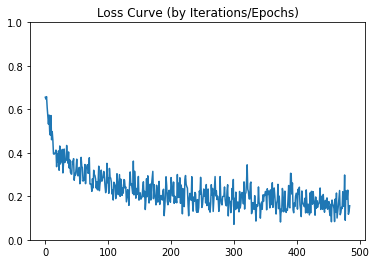

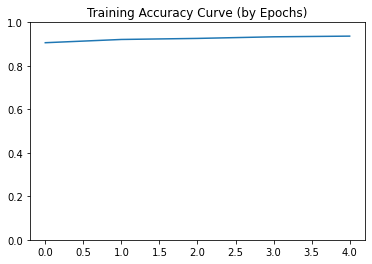

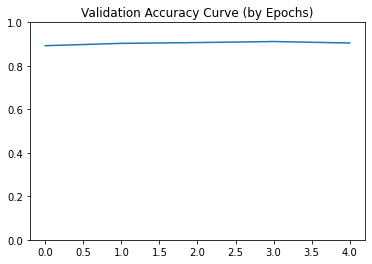

In [0]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()

v=-1
k=-1
validation_errors = np.zeros(0)
train_errors = np.zeros(0)
loss_accumulation = np.zeros(0)

for epoch in range(Epochs):  # loop over the dataset multiple times
    k=k+1
    l=-1
    pred_label = np.zeros((1,3))
    true_label = np.zeros((1,3))
    running_loss = 0.0
    pbar = enumerate(trainloader)#tqdm(enumerate(trainloader))
    #if (k> 1):
    #    break;
    for i, data in pbar:
        l=l+1
        #if (l> 2):
        #    break;
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)        

        # zero the parameter gradients
        optimizer.zero_grad()
        ohe_size = train_batch_size
        if (len(labels)<train_batch_size):
            ohe_size = len(labels)
        one_hot_enc_train = torch.zeros(ohe_size, 3) # Three column encoder for training set
        one_hot_enc_train[torch.arange(ohe_size), labels] = 1         

        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs.cpu(), one_hot_enc_train.cpu())   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        loss_accumulation = np.append(loss_accumulation,loss.item())
        #pbar.set_description(
        #    'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #        epoch, i * len(inputs), len(trainloader.dataset),
        #        100. * i / len(trainloader),
        #        loss.item())#loss.data[0])
        #        )
     
    torch.save(resnet18.state_dict(), 'resnet18_wo_focal_loss.pth')

    #Training accuracy 
    correct = 0
    total = 0
    v=-1
    with torch.no_grad():
        for data in trainloader:
            v=v+1
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
    
            ohe_size = train_batch_size
            if (len(labels)<train_batch_size):
                ohe_size = len(labels)
            one_hot_enc_train = torch.zeros(ohe_size, 3) # Three column encoder for training set
            one_hot_enc_train[torch.arange(ohe_size), labels] = 1            

            # Apply sigmoid function      
            predicted = 1 / (1+torch.exp(-1*outputs.data))
            # Apply prediction threshold 0.5  
            predicted[predicted>=0.5] = 1
            predicted[predicted<0.5] = 0
            labels = one_hot_enc_train.cuda()
            total += (labels.size(0) * 3)
            correct += (predicted == labels).sum().item()
            pred_label = np.append(pred_label,predicted.cpu(),axis=0)
            true_label = np.append(true_label,labels.cpu(),axis=0)

    true_label = np.delete(true_label, 0, axis=0)
    pred_label = np.delete(pred_label, 0, axis=0)
    train_errors = np.append(train_errors,correct / total)
    print("\n\nTraining Accuracy for Epoch:",k)
    print("\n\nConfusion Matrix for Training images")
    print("-------------------------")
    conf = multilabel_confusion_matrix(true_label, pred_label)
    print_confusion_matrix(conf)
    
    pred_label = np.zeros((1,3))
    true_label = np.zeros((1,3))

    #validation accuracy
    correct = 0
    total = 0
    v=-1
    with torch.no_grad():
        for data in validationloader:
            v=v+1
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
    
            ohe_size = validation_batch_size
            if (len(labels)<validation_batch_size):
                ohe_size = len(labels)
            one_hot_enc_validation = torch.zeros(ohe_size, 3) # Three column encoder for training set
            one_hot_enc_validation[torch.arange(ohe_size), labels] = 1            

            # Apply sigmoid function      
            predicted = 1 / (1+torch.exp(-1*outputs.data))
            # Apply prediction threshold 0.5  
            predicted[predicted>=0.5] = 1
            predicted[predicted<0.5] = 0
            labels = one_hot_enc_validation.cuda()
            total += (labels.size(0) * 3)
            correct += (predicted == labels).sum().item()
            pred_label = np.append(pred_label,predicted.cpu(),axis=0)
            true_label = np.append(true_label,labels.cpu(),axis=0)

    true_label = np.delete(true_label, 0, axis=0)
    pred_label = np.delete(pred_label, 0, axis=0)
    validation_errors = np.append(validation_errors,correct / total)
    print("\n\nValidation Accuracy for Epoch:",k)
    print("\n\nConfusion Matrix for validation images")
    print("-------------------------")
    conf = multilabel_confusion_matrix(true_label, pred_label)
    print_confusion_matrix(conf)
print('Finished Training')
plt.title("Loss Curve (by Iterations/Epochs)")
plt.ylim(0, 1)
plt.plot(loss_accumulation)
plt.show()

plt.title("Training Accuracy Curve (by Epochs)")
plt.ylim(0, 1)
plt.plot(train_errors)
plt.show()

plt.title("Validation Accuracy Curve (by Epochs)")
plt.ylim(0, 1)
plt.plot(validation_errors)
plt.show()

### Testing (Validation Data) - ResNet18 without Focal Loss

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
pred_label = np.zeros((1,3))
true_label = np.zeros((1,3))
correct = 0
total = 0
v=-1
with torch.no_grad():
    for data in validationloader:
        v=v+1
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)

        ohe_size = validation_batch_size
        if (len(labels)<validation_batch_size):
            ohe_size = len(labels)
        one_hot_enc_validation = torch.zeros(ohe_size, 3) # Three column encoder for training set
        one_hot_enc_validation[torch.arange(ohe_size), labels] = 1            

        # Apply sigmoid function      
        predicted = 1 / (1+torch.exp(-1*outputs.data))
        # Apply prediction threshold 0.5  
        predicted[predicted>=0.5] = 1
        predicted[predicted<0.5] = 0
        labels = one_hot_enc_validation.cuda()
        total += (labels.size(0) * 3)
        correct += (predicted == labels).sum().item()
        pred_label = np.append(pred_label,predicted.cpu(),axis=0)
        true_label = np.append(true_label,labels.cpu(),axis=0)

true_label = np.delete(true_label, 0, axis=0)
pred_label = np.delete(pred_label, 0, axis=0)

print("-------------------------")
print("Accuracy")
print("-------------------------")
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))
print("\n")
print("F1 Measure")
print("-------------------------")
print('F1 measure on the validation images:', f1_score(true_label, pred_label, average='weighted'))
print("\n")
print_confusion_matrix(conf)

-------------------------
Accuracy
-------------------------
Accuracy of the network on the validation images: 91 %


F1 Measure
-------------------------
F1 measure on the validation images: 0.8491474350765741





COVID vs other Classes     600     0
                           28     0

Normal vs other Classes    182     46
                           28     372

Pneumonia vs other Classes 396     32
                           45     155


### Training - ResNet18 With Focal Loss



Training Accuracy for Epoch: 0


Confusion Matrix for Training images
-------------------------



COVID vs other Classes     6000     0
                           154     46

Normal vs other Classes    1937     263
                           201     3799

Pneumonia vs other Classes 3920     280
                           286     1714


Validation Accuracy for Epoch: 0


Confusion Matrix for validation images
-------------------------



COVID vs other Classes     600     0
                           28     0

Normal vs other Classes    182     46
                           31     369

Pneumonia vs other Classes 401     27
                           40     160


Training Accuracy for Epoch: 1


Confusion Matrix for Training images
-------------------------



COVID vs other Classes     6000     0
                           159     41

Normal vs other Classes    1954     246
                           185     3815

Pneumonia vs other Classes 3928     272
                           276

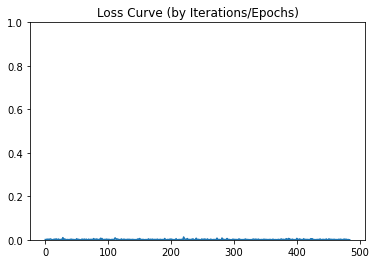

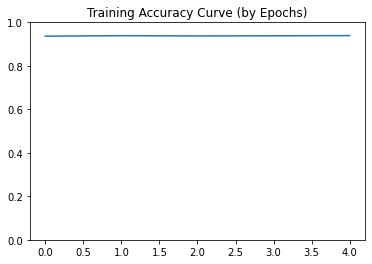

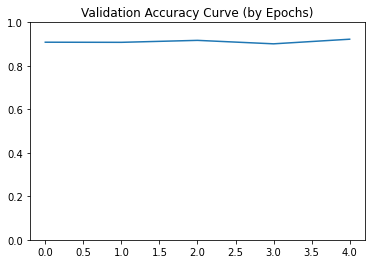

In [0]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()

v=-1
k=-1
validation_errors = np.zeros(0)
train_errors = np.zeros(0)
loss_accumulation = np.zeros(0)

for epoch in range(Epochs):  # loop over the dataset multiple times
    k=k+1
    l=-1
    pred_label = np.zeros((1,3))
    true_label = np.zeros((1,3))
    running_loss = 0.0
    pbar = enumerate(trainloader)#tqdm(enumerate(trainloader))
    #if (k> 1):
    #    break;
    for i, data in pbar:
        l=l+1
        #if (l> 2):
        #    break;
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)        

        # zero the parameter gradients
        optimizer.zero_grad()
        ohe_size = train_batch_size
        if (len(labels)<train_batch_size):
            ohe_size = len(labels)
        one_hot_enc_train = torch.zeros(ohe_size, 3) # Three column encoder for training set
        one_hot_enc_train[torch.arange(ohe_size), labels] = 1         

        outputs = resnet18(inputs)               #----> forward pass
        loss = focal_loss(outputs.cpu(), one_hot_enc_train.cpu())   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        loss_accumulation = np.append(loss_accumulation,loss.item())
        #pbar.set_description(
        #    'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #        epoch, i * len(inputs), len(trainloader.dataset),
        #        100. * i / len(trainloader),
        #        loss.item())#loss.data[0])
        #        )
     
    torch.save(resnet18.state_dict(), 'resnet18_focal_loss.pth')

    #Training accuracy 
    correct = 0
    total = 0
    v=-1
    with torch.no_grad():
        for data in trainloader:
            v=v+1
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
    
            ohe_size = train_batch_size
            if (len(labels)<train_batch_size):
                ohe_size = len(labels)
            one_hot_enc_train = torch.zeros(ohe_size, 3) # Three column encoder for training set
            one_hot_enc_train[torch.arange(ohe_size), labels] = 1            

            # Apply sigmoid function      
            predicted = 1 / (1+torch.exp(-1*outputs.data))
            # Apply prediction threshold 0.5  
            predicted[predicted>=0.5] = 1
            predicted[predicted<0.5] = 0
            labels = one_hot_enc_train.cuda()
            total += (labels.size(0) * 3)
            correct += (predicted == labels).sum().item()
            pred_label = np.append(pred_label,predicted.cpu(),axis=0)
            true_label = np.append(true_label,labels.cpu(),axis=0)

    true_label = np.delete(true_label, 0, axis=0)
    pred_label = np.delete(pred_label, 0, axis=0)
    train_errors = np.append(train_errors,correct / total)
    print("\n\nTraining Accuracy for Epoch:",k)
    print("\n\nConfusion Matrix for Training images")
    print("-------------------------")
    conf = multilabel_confusion_matrix(true_label, pred_label)
    print_confusion_matrix(conf)

    pred_label = np.zeros((1,3))
    true_label = np.zeros((1,3))
    
    #validation accuracy
    correct = 0
    total = 0
    v=-1
    with torch.no_grad():
        for data in validationloader:
            v=v+1
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
    
            ohe_size = validation_batch_size
            if (len(labels)<validation_batch_size):
                ohe_size = len(labels)
            one_hot_enc_validation = torch.zeros(ohe_size, 3) # Three column encoder for training set
            one_hot_enc_validation[torch.arange(ohe_size), labels] = 1            

            # Apply sigmoid function      
            predicted = 1 / (1+torch.exp(-1*outputs.data))
            # Apply prediction threshold 0.5  
            predicted[predicted>=0.5] = 1
            predicted[predicted<0.5] = 0
            labels = one_hot_enc_validation.cuda()
            total += (labels.size(0) * 3)
            correct += (predicted == labels).sum().item()
            pred_label = np.append(pred_label,predicted.cpu(),axis=0)
            true_label = np.append(true_label,labels.cpu(),axis=0)

    true_label = np.delete(true_label, 0, axis=0)
    pred_label = np.delete(pred_label, 0, axis=0)
    validation_errors = np.append(validation_errors,correct / total)
    print("\n\nValidation Accuracy for Epoch:",k)
    print("\n\nConfusion Matrix for validation images")
    print("-------------------------")
    conf = multilabel_confusion_matrix(true_label, pred_label)
    print_confusion_matrix(conf)
print('Finished Training')
plt.title("Loss Curve (by Iterations/Epochs)")
plt.ylim(0, 1)
plt.plot(loss_accumulation)
plt.show()

plt.title("Training Accuracy Curve (by Epochs)")
plt.ylim(0, 1)
plt.plot(train_errors)
plt.show()

plt.title("Validation Accuracy Curve (by Epochs)")
plt.ylim(0, 1)
plt.plot(validation_errors)
plt.show()

### Testing (Validation Data) - ResNet18 With Focal Loss

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
pred_label = np.zeros((1,3))
true_label = np.zeros((1,3))
correct = 0
total = 0
v=-1
with torch.no_grad():
    for data in validationloader:
        v=v+1
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)

        ohe_size = validation_batch_size
        if (len(labels)<validation_batch_size):
            ohe_size = len(labels)
        one_hot_enc_validation = torch.zeros(ohe_size, 3) # Three column encoder for training set
        one_hot_enc_validation[torch.arange(ohe_size), labels] = 1            

        # Apply sigmoid function      
        predicted = 1 / (1+torch.exp(-1*outputs.data))
        # Apply prediction threshold 0.5  
        predicted[predicted>=0.5] = 1
        predicted[predicted<0.5] = 0
        labels = one_hot_enc_validation.cuda()
        total += (labels.size(0) * 3)
        correct += (predicted == labels).sum().item()
        pred_label = np.append(pred_label,predicted.cpu(),axis=0)
        true_label = np.append(true_label,labels.cpu(),axis=0)

true_label = np.delete(true_label, 0, axis=0)
pred_label = np.delete(pred_label, 0, axis=0)

print("-------------------------")
print("Accuracy")
print("-------------------------")
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))
print("\n")
print("F1 Measure")
print("-------------------------")
print('F1 measure on the validation images:', f1_score(true_label, pred_label, average='weighted'))
print("\n")
print_confusion_matrix(conf)

-------------------------
Accuracy
-------------------------
Accuracy of the network on the validation images: 91 %


F1 Measure
-------------------------
F1 measure on the validation images: 0.8494914509062741





COVID vs other Classes     600     0
                           28     0

Normal vs other Classes    193     35
                           25     375

Pneumonia vs other Classes 399     29
                           29     171


### Load pre-trained VGG-16

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
#print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


### Changes in FC Layers

In [0]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())
features = features[:-1]
features.extend([nn.Linear(4096, len(class_names))])
vgg16.classifier = nn.Sequential(*features)
#print(vgg16)

### UnFreezing all the layers

In [0]:
for param in vgg16.features.parameters():
    param.requires_grad = True

### Loss function and optimizer

In [0]:
Epochs = 5
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

### Training - VGG16 without Focal Loss



Training Accuracy for Epoch: 0


Confusion Matrix for Training images
-------------------------



COVID vs other Classes     6000     0
                           196     4

Normal vs other Classes    1824     376
                           200     3800

Pneumonia vs other Classes 3898     302
                           387     1613


Validation Accuracy for Epoch: 0


Confusion Matrix for validation images
-------------------------



COVID vs other Classes     600     0
                           28     0

Normal vs other Classes    179     49
                           14     386

Pneumonia vs other Classes 407     21
                           40     160


Training Accuracy for Epoch: 1


Confusion Matrix for Training images
-------------------------



COVID vs other Classes     5986     14
                           127     73

Normal vs other Classes    1975     225
                           287     3713

Pneumonia vs other Classes 3815     385
                           251

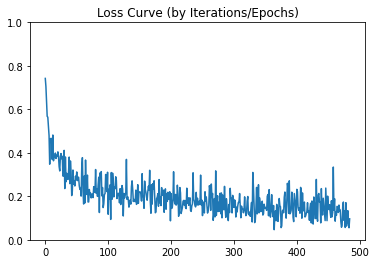

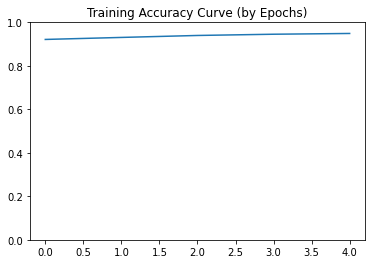

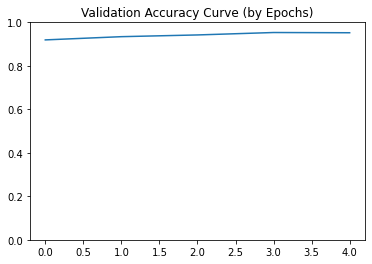

In [0]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

v=-1
k=-1
validation_errors = np.zeros(0)
train_errors = np.zeros(0)
loss_accumulation = np.zeros(0)

for epoch in range(Epochs):  # loop over the dataset multiple times
    k=k+1
    l=-1
    pred_label = np.zeros((1,3))
    true_label = np.zeros((1,3))
    running_loss = 0.0
    pbar = enumerate(trainloader)#tqdm(enumerate(trainloader))
    #if (k> 1):
    #    break;
    for i, data in pbar:
        l=l+1
        #if (l> 2):
        #    break;
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)        

        # zero the parameter gradients
        optimizer.zero_grad()
        ohe_size = train_batch_size
        if (len(labels)<train_batch_size):
            ohe_size = len(labels)
        one_hot_enc_train = torch.zeros(ohe_size, 3) # Three column encoder for training set
        one_hot_enc_train[torch.arange(ohe_size), labels] = 1         

        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs.cpu(), one_hot_enc_train.cpu())   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        loss_accumulation = np.append(loss_accumulation,loss.item())
        #pbar.set_description(
        #    'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #        epoch, i * len(inputs), len(trainloader.dataset),
        #        100. * i / len(trainloader),
        #        loss.item())#loss.data[0])
        #        )
     
    torch.save(vgg16.state_dict(), 'vgg16_wo_focal_loss.pth')

    #Training accuracy 
    correct = 0
    total = 0
    v=-1
    with torch.no_grad():
        for data in trainloader:
            v=v+1
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
    
            ohe_size = train_batch_size
            if (len(labels)<train_batch_size):
                ohe_size = len(labels)
            one_hot_enc_train = torch.zeros(ohe_size, 3) # Three column encoder for training set
            one_hot_enc_train[torch.arange(ohe_size), labels] = 1            

            # Apply sigmoid function      
            predicted = 1 / (1+torch.exp(-1*outputs.data))
            # Apply prediction threshold 0.5  
            predicted[predicted>=0.5] = 1
            predicted[predicted<0.5] = 0
            labels = one_hot_enc_train.cuda()
            total += (labels.size(0) * 3)
            correct += (predicted == labels).sum().item()
            pred_label = np.append(pred_label,predicted.cpu(),axis=0)
            true_label = np.append(true_label,labels.cpu(),axis=0)

    true_label = np.delete(true_label, 0, axis=0)
    pred_label = np.delete(pred_label, 0, axis=0)
    train_errors = np.append(train_errors,correct / total)
    print("\n\nTraining Accuracy for Epoch:",k)
    print("\n\nConfusion Matrix for Training images")
    print("-------------------------")
    conf = multilabel_confusion_matrix(true_label, pred_label)
    print_confusion_matrix(conf)

    pred_label = np.zeros((1,3))
    true_label = np.zeros((1,3))    

    #validation accuracy
    correct = 0
    total = 0
    v=-1
    with torch.no_grad():
        for data in validationloader:
            v=v+1
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
    
            ohe_size = validation_batch_size
            if (len(labels)<validation_batch_size):
                ohe_size = len(labels)
            one_hot_enc_validation = torch.zeros(ohe_size, 3) # Three column encoder for training set
            one_hot_enc_validation[torch.arange(ohe_size), labels] = 1            

            # Apply sigmoid function      
            predicted = 1 / (1+torch.exp(-1*outputs.data))
            # Apply prediction threshold 0.5  
            predicted[predicted>=0.5] = 1
            predicted[predicted<0.5] = 0
            labels = one_hot_enc_validation.cuda()
            total += (labels.size(0) * 3)
            correct += (predicted == labels).sum().item()
            pred_label = np.append(pred_label,predicted.cpu(),axis=0)
            true_label = np.append(true_label,labels.cpu(),axis=0)

    true_label = np.delete(true_label, 0, axis=0)
    pred_label = np.delete(pred_label, 0, axis=0)
    validation_errors = np.append(validation_errors,correct / total)
    print("\n\nValidation Accuracy for Epoch:",k)
    print("\n\nConfusion Matrix for validation images")
    print("-------------------------")
    conf = multilabel_confusion_matrix(true_label, pred_label)
    print_confusion_matrix(conf)
print('Finished Training')
plt.title("Loss Curve (by Iterations/Epochs)")
plt.ylim(0, 1)
plt.plot(loss_accumulation)
plt.show()

plt.title("Training Accuracy Curve (by Epochs)")
plt.ylim(0, 1)
plt.plot(train_errors)
plt.show()

plt.title("Validation Accuracy Curve (by Epochs)")
plt.ylim(0, 1)
plt.plot(validation_errors)
plt.show()

### Testing (Validation Data) - VGG16 without Focal Loss

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
pred_label = np.zeros((1,3))
true_label = np.zeros((1,3))
correct = 0
total = 0
v=-1
with torch.no_grad():
    for data in validationloader:
        v=v+1
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)

        ohe_size = validation_batch_size
        if (len(labels)<validation_batch_size):
            ohe_size = len(labels)
        one_hot_enc_validation = torch.zeros(ohe_size, 3) # Three column encoder for training set
        one_hot_enc_validation[torch.arange(ohe_size), labels] = 1            

        # Apply sigmoid function      
        predicted = 1 / (1+torch.exp(-1*outputs.data))
        # Apply prediction threshold 0.5  
        predicted[predicted>=0.5] = 1
        predicted[predicted<0.5] = 0
        labels = one_hot_enc_validation.cuda()
        total += (labels.size(0) * 3)
        correct += (predicted == labels).sum().item()
        pred_label = np.append(pred_label,predicted.cpu(),axis=0)
        true_label = np.append(true_label,labels.cpu(),axis=0)

true_label = np.delete(true_label, 0, axis=0)
pred_label = np.delete(pred_label, 0, axis=0)

print("-------------------------")
print("Accuracy")
print("-------------------------")
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))
print("\n")
print("F1 Measure")
print("-------------------------")
print('F1 measure on the validation images:', f1_score(true_label, pred_label, average='weighted'))
print("\n")
print_confusion_matrix(conf)

-------------------------
Accuracy
-------------------------
Accuracy of the network on the validation images: 95 %


F1 Measure
-------------------------
F1 measure on the validation images: 0.9252762842201715





COVID vs other Classes     599     1
                           15     13

Normal vs other Classes    205     23
                           19     381

Pneumonia vs other Classes 410     18
                           14     186


### Training - VGG16 With Focal Loss



Training Accuracy for Epoch: 0


Confusion Matrix for Training images
-------------------------



COVID vs other Classes     5978     22
                           66     134

Normal vs other Classes    1978     222
                           191     3809

Pneumonia vs other Classes 4010     190
                           233     1767


Validation Accuracy for Epoch: 0


Confusion Matrix for validation images
-------------------------



COVID vs other Classes     597     3
                           13     15

Normal vs other Classes    207     21
                           22     378

Pneumonia vs other Classes 413     15
                           18     182


Training Accuracy for Epoch: 1


Confusion Matrix for Training images
-------------------------



COVID vs other Classes     5978     22
                           65     135

Normal vs other Classes    1958     242
                           149     3851

Pneumonia vs other Classes 4026     174
                           

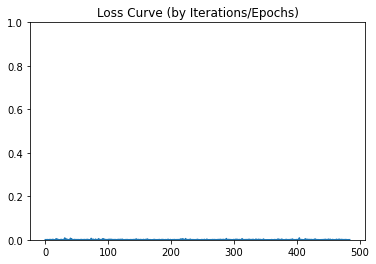

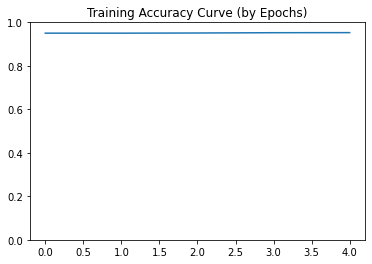

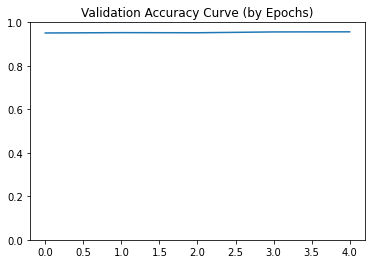

In [0]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

v=-1
k=-1
validation_errors = np.zeros(0)
train_errors = np.zeros(0)
loss_accumulation = np.zeros(0)

for epoch in range(Epochs):  # loop over the dataset multiple times
    k=k+1
    l=-1
    pred_label = np.zeros((1,3))
    true_label = np.zeros((1,3))
    running_loss = 0.0
    pbar = enumerate(trainloader)#tqdm(enumerate(trainloader))
    #if (k> 1):
    #    break;
    for i, data in pbar:
        l=l+1
        #if (l> 2):
        #    break;
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)        

        # zero the parameter gradients
        optimizer.zero_grad()
        ohe_size = train_batch_size
        if (len(labels)<train_batch_size):
            ohe_size = len(labels)
        one_hot_enc_train = torch.zeros(ohe_size, 3) # Three column encoder for training set
        one_hot_enc_train[torch.arange(ohe_size), labels] = 1         

        outputs = vgg16(inputs)               #----> forward pass
        loss = focal_loss(outputs.cpu(), one_hot_enc_train.cpu())   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        loss_accumulation = np.append(loss_accumulation,loss.item())
        #pbar.set_description(
        #    'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #        epoch, i * len(inputs), len(trainloader.dataset),
        #        100. * i / len(trainloader),
        #        loss.item())#loss.data[0])
        #        )
     
    torch.save(vgg16.state_dict(), 'vgg16_focal_loss.pth')

    #Training accuracy 
    correct = 0
    total = 0
    v=-1
    with torch.no_grad():
        for data in trainloader:
            v=v+1
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
    
            ohe_size = train_batch_size
            if (len(labels)<train_batch_size):
                ohe_size = len(labels)
            one_hot_enc_train = torch.zeros(ohe_size, 3) # Three column encoder for training set
            one_hot_enc_train[torch.arange(ohe_size), labels] = 1            

            # Apply sigmoid function      
            predicted = 1 / (1+torch.exp(-1*outputs.data))
            # Apply prediction threshold 0.5  
            predicted[predicted>=0.5] = 1
            predicted[predicted<0.5] = 0
            labels = one_hot_enc_train.cuda()
            total += (labels.size(0) * 3)
            correct += (predicted == labels).sum().item()
            pred_label = np.append(pred_label,predicted.cpu(),axis=0)
            true_label = np.append(true_label,labels.cpu(),axis=0)

    true_label = np.delete(true_label, 0, axis=0)
    pred_label = np.delete(pred_label, 0, axis=0)
    train_errors = np.append(train_errors,correct / total)
    print("\n\nTraining Accuracy for Epoch:",k)
    print("\n\nConfusion Matrix for Training images")
    print("-------------------------")
    conf = multilabel_confusion_matrix(true_label, pred_label)
    print_confusion_matrix(conf)

    pred_label = np.zeros((1,3))
    true_label = np.zeros((1,3))
    
    #validation accuracy
    correct = 0
    total = 0
    v=-1
    with torch.no_grad():
        for data in validationloader:
            v=v+1
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
    
            ohe_size = validation_batch_size
            if (len(labels)<validation_batch_size):
                ohe_size = len(labels)
            one_hot_enc_validation = torch.zeros(ohe_size, 3) # Three column encoder for training set
            one_hot_enc_validation[torch.arange(ohe_size), labels] = 1            

            # Apply sigmoid function      
            predicted = 1 / (1+torch.exp(-1*outputs.data))
            # Apply prediction threshold 0.5  
            predicted[predicted>=0.5] = 1
            predicted[predicted<0.5] = 0
            labels = one_hot_enc_validation.cuda()
            total += (labels.size(0) * 3)
            correct += (predicted == labels).sum().item()
            pred_label = np.append(pred_label,predicted.cpu(),axis=0)
            true_label = np.append(true_label,labels.cpu(),axis=0)

    true_label = np.delete(true_label, 0, axis=0)
    pred_label = np.delete(pred_label, 0, axis=0)
    validation_errors = np.append(validation_errors,correct / total)
    print("\n\nValidation Accuracy for Epoch:",k)
    print("\n\nConfusion Matrix for validation images")
    print("-------------------------")
    conf = multilabel_confusion_matrix(true_label, pred_label)
    print_confusion_matrix(conf)
print('Finished Training')
plt.title("Loss Curve (by Iterations/Epochs)")
plt.ylim(0, 1)
plt.plot(loss_accumulation)
plt.show()

plt.title("Training Accuracy Curve (by Epochs)")
plt.ylim(0, 1)
plt.plot(train_errors)
plt.show()

plt.title("Validation Accuracy Curve (by Epochs)")
plt.ylim(0, 1)
plt.plot(validation_errors)
plt.show()

### Testing (Validation Data) - VGG16 With Focal Loss

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
pred_label = np.zeros((1,3))
true_label = np.zeros((1,3))
correct = 0
total = 0
v=-1
with torch.no_grad():
    for data in validationloader:
        v=v+1
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)

        ohe_size = validation_batch_size
        if (len(labels)<validation_batch_size):
            ohe_size = len(labels)
        one_hot_enc_validation = torch.zeros(ohe_size, 3) # Three column encoder for training set
        one_hot_enc_validation[torch.arange(ohe_size), labels] = 1            

        # Apply sigmoid function      
        predicted = 1 / (1+torch.exp(-1*outputs.data))
        # Apply prediction threshold 0.5  
        predicted[predicted>=0.5] = 1
        predicted[predicted<0.5] = 0
        labels = one_hot_enc_validation.cuda()
        total += (labels.size(0) * 3)
        correct += (predicted == labels).sum().item()
        pred_label = np.append(pred_label,predicted.cpu(),axis=0)
        true_label = np.append(true_label,labels.cpu(),axis=0)

true_label = np.delete(true_label, 0, axis=0)
pred_label = np.delete(pred_label, 0, axis=0)

print("-------------------------")
print("Accuracy")
print("-------------------------")
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))
print("\n")
print("F1 Measure")
print("-------------------------")
print('F1 measure on the validation images:', f1_score(true_label, pred_label, average='weighted'))
print("\n")
print_confusion_matrix(conf)

-------------------------
Accuracy
-------------------------
Accuracy of the network on the validation images: 95 %


F1 Measure
-------------------------
F1 measure on the validation images: 0.9342072431871936





COVID vs other Classes     599     1
                           11     17

Normal vs other Classes    201     27
                           12     388

Pneumonia vs other Classes 418     10
                           21     179


### Testing CSV Export

In [0]:
from distutils.dir_util import copy_tree

# copy subdirectory example
fromDirectory = "/content/A_05_Part_02_Dataset/Test"
toDirectory = "/content/A_05_Part_02_Dataset/Test/normal"

copy_tree(fromDirectory, toDirectory)

['/content/A_05_Part_02_Dataset/Test/normal/570.png',
 '/content/A_05_Part_02_Dataset/Test/normal/17.png',
 '/content/A_05_Part_02_Dataset/Test/normal/362.png',
 '/content/A_05_Part_02_Dataset/Test/normal/147.png',
 '/content/A_05_Part_02_Dataset/Test/normal/583.png',
 '/content/A_05_Part_02_Dataset/Test/normal/243.png',
 '/content/A_05_Part_02_Dataset/Test/normal/86.png',
 '/content/A_05_Part_02_Dataset/Test/normal/392.png',
 '/content/A_05_Part_02_Dataset/Test/normal/300.png',
 '/content/A_05_Part_02_Dataset/Test/normal/233.png',
 '/content/A_05_Part_02_Dataset/Test/normal/561.png',
 '/content/A_05_Part_02_Dataset/Test/normal/119.png',
 '/content/A_05_Part_02_Dataset/Test/normal/49.png',
 '/content/A_05_Part_02_Dataset/Test/normal/528.png',
 '/content/A_05_Part_02_Dataset/Test/normal/138.png',
 '/content/A_05_Part_02_Dataset/Test/normal/433.png',
 '/content/A_05_Part_02_Dataset/Test/normal/259.png',
 '/content/A_05_Part_02_Dataset/Test/normal/197.png',
 '/content/A_05_Part_02_Dataset

In [0]:
def class_order(loader,count):
    #count = 0
    class0 = 0
    class1 = 0
    class2 = 0
    e = enumerate(loader)
    for i, data in e:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)    
        count += labels.size(0)
        class0 += (0 == labels).sum().item() # COVID
        class1 += (1 == labels).sum().item() # Normal
        class2 += (2 == labels).sum().item() # Pneumonia

    print("Total Samples:", count)
    print("Class 0 Samples:", class0)
    print("Class 1 Samples:", class1)
    print("Class 2 Samples:", class2)
    print(train_data.classes)
    one_hot = torch.zeros(count, 3) # Three column encoder for training set

In [0]:
print("\n\nVerification of Class Order")
print("------------------------")
class_order (validationloader,628)




Verification of Class Order
------------------------
Total Samples: 1256
Class 0 Samples: 28
Class 1 Samples: 400
Class 2 Samples: 200
['covid', 'normal', 'pneumonia']


In [0]:
import torch
from torchvision import datasets

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


In [0]:
test_data = ImageFolderWithPaths('/content/A_05_Part_02_Dataset/Test', transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=False)

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix

pred_label = np.zeros((1,3))
imgagearray = np.array([''])
correct = 0
total = 0
class0 = 0
class1 = 0
class2 = 0
v=-1
with torch.no_grad():
    for data in testloader:
        v=v+1
        images, labels, path = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)

        ohe_size = test_batch_size
        if (len(labels)<test_batch_size):
            ohe_size = len(labels)
        one_hot_enc_test = torch.zeros(ohe_size, 3) # Three column encoder for training set
        one_hot_enc_test[torch.arange(ohe_size), labels] = 1            

        # Apply sigmoid function      
        predicted = 1 / (1+torch.exp(-1*outputs.data))
        # Apply prediction threshold 0.5  
        predicted[predicted>=0.5] = 1
        predicted[predicted<0.5] = 0
        pred_label = np.append(pred_label,predicted.cpu(),axis=0)
        img = path[0].split("/")[-1]
        imgagearray = np.append(imgagearray,img)

pred_label = np.delete(pred_label, 0, axis=0) 
imgagearray = np.delete(imgagearray, 0, axis=0) 

#The classes predicted are in order, Covid, Normal, and Pneumonia 
pred_label[:,[1, 2]] = pred_label[:,[2, 1]]

In [0]:
import csv

with open('MSDS17037_results.csv', 'w') as csvfile:
  for i in range(0,len(imgagearray)):
      writer = csv.writer(csvfile, delimiter=',')
      row = []
      row.append(imgagearray[i])
      row.append(pred_label[i,0])
      row.append(pred_label[i,1])
      row.append(pred_label[i,2])
      writer.writerow(row)